In [4]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import nfode

data = np.load('data_test.npz')
t_data = data['t_data']
x_data = data['x_data']

input_dim=2
output_dim=2
inner_dim=64
class ODEModel(nn.Module):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, inner_dim)
        self.fc2 = nn.Linear(inner_dim, inner_dim)
        self.fc3 = nn.Linear(inner_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = torch.load('model.pt')
x0 = x_data[:, 0]
x_preds = nfode.predict(model, t_data, x0)
loss = nn.MSELoss()
x_preds = torch.tensor(x_preds).requires_grad_(True)

params_matrix = np.load('params_matrix.npy')

/tmp/ipykernel_52424/2348238919.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model.pt')
/tmp/ipykernel_52424/2348238919.py:36: UserWarning: To co

/home/liyilin/miniconda3/envs/gpuenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/liyilin/miniconda3/envs/gpuenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/liyilin/miniconda3/envs/gpuenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/liyilin/miniconda3/envs/gpuenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

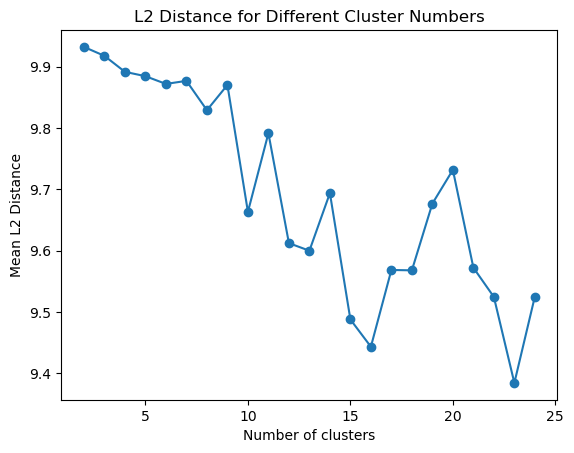

In [5]:
l2_distances = []
for k in range(2, 25):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(params_matrix)
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    mean_l2_distance = np.sum([np.linalg.norm(params_matrix[i,:] - centers[labels[i],:]) for i in range(60)]) / 60
    l2_distances.append(mean_l2_distance)

# 绘制聚类数和L2距离的关系图
plt.plot(range(2, 25), l2_distances, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Mean L2 Distance')
plt.title('L2 Distance for Different Cluster Numbers')
plt.show()

/home/liyilin/miniconda3/envs/gpuenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


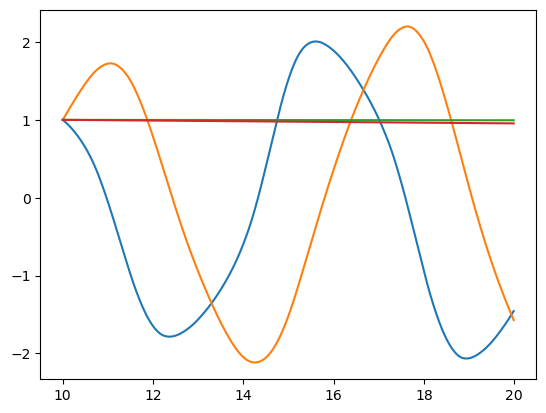

In [6]:
avg_distances = np.zeros(len(params_matrix))

for i in range(len(params_matrix)):
    total_distance = 0
    for j in range(len(params_matrix)):
        if i != j:  
            distance = np.linalg.norm(params_matrix[i] - params_matrix[j])
            total_distance += distance
    avg_distances[i] = total_distance / (len(params_matrix) - 1)

indices_to_remove = np.argsort(avg_distances)[-10:]

params_matrix_filtered = np.delete(params_matrix, indices_to_remove, axis=0)

kmeans = KMeans(n_clusters=1, random_state=42).fit(params_matrix_filtered)
center = kmeans.cluster_centers_
center = center.reshape(-1)
params, flat_params, param_types, param_shapes = nfode.flatten_params(model)
modified_model = nfode.update_model_params(model, center, param_shapes)
x_modified_preds = nfode.predict(modified_model, t_data, x0)
plt.plot(t_data, x_preds.detach().numpy().reshape(1000,2))
plt.plot(t_data, x_modified_preds.reshape(1000,2))

[0.00544932 0.00533042 0.00522094]


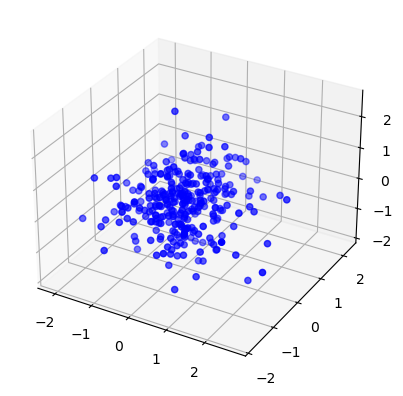

In [7]:
pca = PCA(n_components=3)
params_pca = pca.fit_transform(params_matrix)
print(pca.explained_variance_ratio_)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(params_pca[:,0], params_pca[:,1], params_pca[:,2], c='b', marker='o')

In [8]:
df = pd.DataFrame(params_matrix, columns=[f'Feature {i+1}' for i in range(params_matrix.shape[1])])

correlation_matrix = df.corr()